# Rapport du TP4 - Clustering
### Duc Hau NGUYEN - Mohammed

Importation des dépendances liées aux TP:

In [2]:
import numpy as np
from glob import glob

# scikit-learn
from sklearn import datasets, metrics
from sklearn.cluster import DBSCAN

# plot
import matplotlib.pyplot as plt

In [3]:
from sklearn.utils import check_X_y, check_random_state, safe_indexing, deprecated
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
np.seterr(divide='ignore', invalid='ignore')
def check_number_of_labels(n_labels, n_samples):
    if not 1 < n_labels < n_samples:
        raise ValueError("Number of labels is %d. Valid values are 2 "
"to n_samples - 1 (inclusive)" % n_labels)

def davies_bouldin_score(X, labels):
    X, labels = check_X_y(X, labels)
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    n_samples, _ = X.shape
    n_labels = len(le.classes_)
    check_number_of_labels(n_labels, n_samples)

    intra_dists = np.zeros(n_labels)
    centroids = np.zeros((n_labels, len(X[0])), dtype=np.float)
    for k in range(n_labels):
        cluster_k = safe_indexing(X, labels == k)
        centroid = cluster_k.mean(axis=0)
        centroids[k] = centroid
        intra_dists[k] = np.average(pairwise_distances(
            cluster_k, [centroid]))

    centroid_distances = pairwise_distances(centroids)

    if np.allclose(intra_dists, 0) or np.allclose(centroid_distances, 0):
        return 0.0

    score = (intra_dists[:, None] + intra_dists) / centroid_distances
    score[score == np.inf] = np.nan
    return np.mean(np.nanmax(score, axis=1))

## Partie 1

Récupérer les jeux de données

In [10]:
dataset = np.loadtxt('cham-data/t4.8k.dat')
print("Dataset loaded, dimension: ", dataset.shape)

print("L'écart-type de dataset:", np.std(dataset, axis=0))

Dataset loaded, dimension:  (8000, 2)
L'écart-type de dataset: [157.98664751  73.64845164]


**Alternative**: Charger toutes les dataset

In [5]:
files = glob('cham-data/*')
fragments = [np.loadtxt(file, dtype=float) for file in files]
dataset = np.concatenate(fragments)

print("Dataset loaded, dimension: ", dataset.shape)

print("L'écart-type de dataset:", np.std(dataset, axis=0))

Dataset loaded, dimension:  (34000, 2)
L'écart-type de dataset: [197.16266356 114.32723419]


Appliquez la méthode DBSCAN de scikit-learn sur ces données.  

In [11]:
# Apprentissage
clustering = DBSCAN(eps=7).fit(dataset)

# Résultat
labels = clustering.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Nombre de cluster:",n_clusters)

Nombre de cluster: 23


Analysez les résultats obtenus

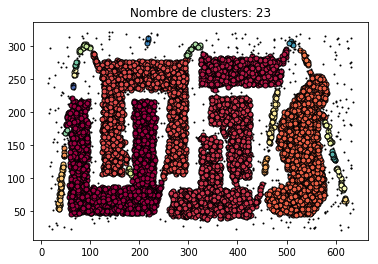

In [12]:
# Color mask for labeled points
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

for k, col in zip(unique_labels, colors):
    
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    # afficher les données de cluster
    xy = dataset[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=5)

    # noises
    xy = dataset[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=1)

plt.title('Nombre de clusters: %d' % n_clusters)
plt.show()

**Bilan de métric**:

In [13]:
def bilan_header(param_name):
    print(param_name, "\t| Nb Cluster \u2192 \t| Silhouette \u2191 \t| Davies Bouldin \u2193")
    print("===========================================================")
    
def bilan(param_val, dataset, cluster): 
    
    silhouette = metrics.silhouette_score(dataset, cluster, metric='euclidean')
    davies_bouldin = davies_bouldin_score(dataset,cluster)
    
    print(
        param_val, "\t|",
        len(set(labels)) - (1 if -1 in labels else 0), "\t\t|", 
        "%.4f" % silhouette, "\t|",
        "%.2f" % davies_bouldin
         )

Choix de `epsilon`

In [14]:
bilan_header("eps")
for eps in range(1,24,2):
    clustering = DBSCAN(
        metric = 'euclidean',
        eps=eps,
        min_samples = 5
    ).fit(dataset)
    labels = clustering.labels_
    bilan(eps, dataset, labels)

eps 	| Nb Cluster → 	| Silhouette ↑ 	| Davies Bouldin ↓
1 	| 1 		| -0.0320 	| 0.85
3 	| 466 		| -0.2249 	| 1.41
5 	| 61 		| -0.4071 	| 3.44
7 	| 23 		| -0.2279 	| 1.58
9 	| 8 		| -0.2534 	| 1.99
11 	| 5 		| -0.3487 	| 2.76
13 	| 4 		| -0.2438 	| 3.06
15 	| 5 		| -0.3066 	| 2.95
17 	| 4 		| -0.1621 	| 3.37
19 	| 6 		| -0.2321 	| 1.47
21 	| 2 		| 0.2057 	| 3.28
23 	| 1 		| 0.3252 	| 9.84


Choix de `min_samples`

In [15]:
bilan_header("min_samp")
for min_samples in range(1,24,2):
    clustering = DBSCAN(
        metric = 'euclidean',
        eps=7, 
        min_samples=min_samples
    ).fit(dataset)
    labels = clustering.labels_
    bilan(min_samples, dataset, labels)
    

min_samp 	| Nb Cluster → 	| Silhouette ↑ 	| Davies Bouldin ↓
1 	| 231 		| -0.6773 	| 0.83
3 	| 30 		| -0.3454 	| 1.43
5 	| 23 		| -0.2279 	| 1.58
7 	| 26 		| -0.2045 	| 1.85
9 	| 20 		| -0.1739 	| 1.71
11 	| 15 		| -0.1201 	| 2.40
13 	| 16 		| -0.0478 	| 2.52
15 	| 36 		| -0.1151 	| 1.87
17 	| 68 		| -0.1217 	| 1.67
19 	| 95 		| -0.1536 	| 1.60
21 	| 77 		| -0.3391 	| 1.41
23 	| 49 		| -0.5219 	| 1.47


## Partie 2
### Algorithme SNN

In [1]:
import numpy as np
from numpy import linalg as la

# scikit-learn
from sklearn import datasets, metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph, NearestNeighbors

# plot
import matplotlib.pyplot as plt

In [2]:
dataset = np.loadtxt('cham-data/t4.8k.dat')

Paramètre

In [117]:
X = dataset
k = 10
threshold_percentage = 0.2 # min = 0, max = 1
symmetric = True
n_clusters = 100
noise_percentage = 0.2 # Percentage of linking power to be ignored
step = 100

#### 1. Construct similarity mattrix

(save in file to avoid learn time)

In [6]:
similarity_graph = kneighbors_graph(
    X, 
    n_neighbors = X.shape[0] - 1,
    mode='distance', 
    metric='euclidean',
     p=2) # n x n

similarity_matrix = similarity_graph.toarray()
similarity_matrix = 1 / (1 + similarity_matrix)
np.save('similarity_matrix', similarity_matrix)

**(check point)**

In [40]:
similarity_matrix = np.load('similarity_matrix.npy')
print("similarity_matrix loaded, dimension",similarity_matrix.shape)

similarity_matrix loaded, dimension (8000, 8000)


#### 2. Sparsify the similarity matrix using k-nn sparsification

In [63]:
neigh = NearestNeighbors(n_neighbors = k, n_jobs=-1)
neigh.fit(similarity_matrix)
k_neighbor_indices = neigh.kneighbors(return_distance = False)
np.save('k_neighbor_indices', k_neighbor_indices)

**(check point)**

In [64]:
k_neighbor_indices = np.load('k_neighbor_indices.npy')
print("k_neighbor_indices loaded, dimension",k_neighbor_indices.shape)

k_neighbor_indices loaded, dimension (8000, 10)


#### 3. Construct the shared nearest neighbor graph from k-nn sparsified similarity matrix

In [80]:
linking_matrix = np.zeros(similarity_matrix.shape)
linking_matrix[np.arange(similarity_matrix.shape[0])[:, None], k_neighbor_indices] = 1
print(linking_matrix)
if symmetric :
    linking_matrix = (linking_matrix + linking_matrix.T)
    linking_matrix = linking_matrix + linking_matrix.T
    linking_matrix[ np.where(linking_matrix > 1) ] = 1 
np.save('linking_matrix', linking_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
# Verify if we have sum >= k at every line
np.sum(linking_matrix, axis=1)

array([10., 12., 10., ..., 10., 11., 14.])

**(check point)**

In [8]:
linking_matrix = np.load('linking_matrix.npy')
print("linking_matrix loaded, dimension",linking_matrix.shape)

linking_matrix loaded, dimension (8000, 8000)


#### 4. For every point in the graph, calculate the total strength of links coming out of the point. (Steps 1-4 are identical to the Jarvis – Patrick scheme.) 

In [24]:
shared_matrix = la.matrix_power(linking_matrix, 2)
np.fill_diagonal(shared_matrix, 0)
np.save('shared_matrix', shared_matrix)

**(check point)**

In [4]:
shared_matrix = np.load('shared_matrix.npy')
print("shared_matrix loaded, dimension",shared_matrix.shape)

shared_matrix loaded, dimension (8000, 8000)


#### 5. Identify representative points by choosing the points that have high total link strength.
#### 6. Identify noise points by choosing the points that have low total link strength and remove them. 

In [96]:
linking_power = np.sum(shared_matrix, axis = 0)
cluster_centers = np.argpartition(linking_power, -n_clusters)[-n_clusters:]

noise_threshold = noise_percentage * (np.max(linking_power) - np.min(linking_power)) + np.min(linking_power)
noises = np.where(linking_power < noise_threshold)[0]
print("Nb cluster centers:", cluster_centers.shape[0])
print("Nb noises:", noises.shape[0])

Nb cluster centers: 3570
Nb noises: 2


#### 7. Remove all links that have weight smaller than a threshold. 

In [33]:
threshold = threshold_percentage * np.max(shared_matrix)
shared_matrix[np.where(shared_matrix < threshold)] = 0

#### 8. Take connected components of points to form clusters, where every point in a cluster is either a representative point or is connected to a representative point

In [97]:
# affect labels:
_labels = np.zeros(similarity_matrix.shape[0])
_labels = np.argmax(shared_matrix,axis=1)
_labels[cluster_centers] = cluster_centers
_lables[noises] = -1

In [99]:
no_cluster = (np.isin(_labels, cluster_centers, invert=True)) & _labels > 0
print('no_cluster = ', np.sum(no_cluster))
_last_n_cluster = -1
while np.sum(no_cluster) != _last_n_cluster and np.sum(no_cluster) > 0:
    
    _last_n_cluster = np.sum(no_cluster)
    
    _labels[no_cluster] = _labels[_labels[no_cluster]] # Inceptionnnnnnnnnnnnn
    no_cluster = (np.isin(_labels, cluster_centers, invert=True)) & _labels > 0
    print('no_cluster = ', np.sum(no_cluster))


no_cluster =  1530
no_cluster =  731
no_cluster =  691
no_cluster =  689
no_cluster =  689


### Customized step 5-8:

In [118]:
linking_power = np.sum(shared_matrix, axis = 0)
threshold = linking_power.shape[0] * noise_percentage

for n_clusters in range(1,linking_power.shape[0], step):
    cluster_centers = np.argpartition(linking_power, -n_clusters)[-n_clusters:]
    
    _labels = np.zeros(similarity_matrix.shape[0])
    _labels = np.argmax(shared_matrix,axis=1)
    _labels[cluster_centers] = cluster_centers
    
    unclassed = np.isin(_labels, cluster_centers, invert=True)
    nb_unclassed = np.sum(unclassed) 
    _last_nb_unclassed = -1
    
    while nb_unclassed != _last_nb_unclassed and nb_unclassed > threshold:
    
        _last_nb_unclassed = np.sum(unclassed)

        _labels[unclassed] = _labels[_labels[unclassed]]
        unclassed = np.isin(_labels, cluster_centers, invert=True)
        nb_unclassed = np.sum(unclassed)
        
    print('n_cluster = ', n_clusters, 'noises = ', np.sum(unclassed))
    if nb_unclassed <= threshold and nb_unclassed != 0:
        break

_labels[nb_unclassed] = -1

n_cluster =  1 noises =  7982
n_cluster =  101 noises =  7461
n_cluster =  201 noises =  7085
n_cluster =  301 noises =  6729
n_cluster =  401 noises =  6412
n_cluster =  501 noises =  6154
n_cluster =  601 noises =  5909
n_cluster =  701 noises =  5699
n_cluster =  801 noises =  5455
n_cluster =  901 noises =  5275
n_cluster =  1001 noises =  5121
n_cluster =  1101 noises =  4967
n_cluster =  1201 noises =  4830
n_cluster =  1301 noises =  4670
n_cluster =  1401 noises =  4543
n_cluster =  1501 noises =  4425
n_cluster =  1601 noises =  4271
n_cluster =  1701 noises =  4138
n_cluster =  1801 noises =  4031
n_cluster =  1901 noises =  3929
n_cluster =  2001 noises =  3841
n_cluster =  2101 noises =  3734
n_cluster =  2201 noises =  3635
n_cluster =  2301 noises =  3539
n_cluster =  2401 noises =  3431
n_cluster =  2501 noises =  3360
n_cluster =  2601 noises =  3272
n_cluster =  2701 noises =  3204
n_cluster =  2801 noises =  3132
n_cluster =  2901 noises =  3046
n_cluster =  3001 nois

In [36]:
clustering = DBSCAN(
    metric = 'precomputed',
    eps= np.max(shared_matrix)/200,
    n_jobs=-1
).fit(shared_matrix)

In [115]:
#labels = clustering.labels_
labels = _labels
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Nombre de cluster:",n_clusters)

Nombre de cluster: 7731


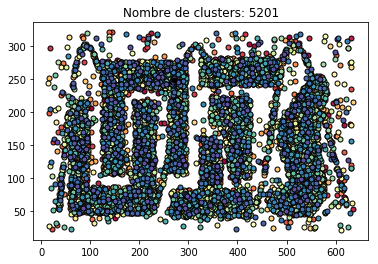

In [119]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

for k, col in zip(unique_labels, colors):
    
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    # afficher les données de cluster
    xy = dataset[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=5)

    # noises
    xy = dataset[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=1)

plt.title('Nombre de clusters: %d' % n_clusters)
plt.show()

**Testing**:

In [54]:
a = np.matrix([[3,2,0],[2,0,5],[7,1,5]])
np.argmax(a,axis=1)

matrix([[0],
        [2],
        [0]], dtype=int64)

In [39]:
kth = 3
m = np.matrix([[1,2,3,7,8,1],[6,4,5,7,6,15]])
idx = np.argpartition(m, kth=kth)
m[np.arange(m.shape[0])[:, None], idx[:, :kth]] = 0

print('top ' , kth , ' =', top)
print('snn = ', m)

top  3  = [[5157 4610 6609 ... 2707 2452 1377]
 [6366 6797 5340 ... 2451  880  714]
 [5489 5949 6233 ... 4982 1857 1762]
 ...
 [6616 7107 6469 ... 2051 1820 1801]
 [6493 5057 7051 ... 2983 2966 2222]
 [6227 7503 3923 ... 2511 2212 1336]]
snn =  [[ 0  0  3  7  8  0]
 [ 6  0  0  7  0 15]]


In [41]:
print('test axis 1 =', np.sum(m, axis=1))
print('test axis 0 =', np.sum(m, axis=0))

test axis 1 = [[18]
 [28]]
test axis 0 = [[ 6  0  3 14  8 15]]
